# Assignment 1: GloVe
_Word Representations and Language Models (WS 24/25)_

Group Members: Ludmila Bajuk, Buket Sak, Alexander Weyhe
***

In this first graded assignment is divided into two sections tasks. We will work with GloVe models trained on Wikipedia data and Twitter data to complete the following tasks: 

1. We will evaluate GloVe's word representations by performing a similarity comparison of word pairs. Obtained similarity scores are then evaluated against human-labeled word pairs. Subsequently, we ask you to explore and interpret the results.
2. We will evaluate GloVe's performance in word analogy tasks and compare results across models.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#FFF2CC;border-color:#D6B656;color:#856404">
<b>How to Submit the Assignment</b>

Please work on this assignment in groups of two or three. Make sure to add your names to this files header. After completion, share this assignment with me (<b>Julian Schelb - <a target="blank" href="https://www.kaggle.com/julianschelb">https://www.kaggle.com/julianschelb</a></b>) due Wednesday, 6th November, 12:00. Use the upper-right share button as instructed in the tutorial. In ILIAS, submit this notebook as response to Assignment 01.
</div>

In [1]:
# Use gensim API
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

# You can use additional packages
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import pandas as pd
import numpy as np

## Task 1: Evaluate GloVe against Human Annotators

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load the Dataset</b> 
</div>

First, we will download our evaluation data set ("wordsim353") containing word pairs labelled by humans in terms of their similarity. To access the data, add [this](https://www.kaggle.com/datasets/julianschelb/wordsim353-crowd) dataset to your notebook. 

**How to add data to a notebook?**

* Click on "+ Add data" (in the top-right)
* Search for "WordSim353 (crowd)" 
* Use the "plus" button next to the datasets title

**How to access the dataset?**

You find all added datasets listed in the "Data" section under "Input". Datasets are places in the "input" directory. In our case, use the following path to read the CSV file: "../input/wordsim353-crowd/wordsim353crowd.csv"

In [2]:
# Read the evaluation data with pandas
data_wordsim = pd.read_csv("/kaggle/input/wordsim353-crowd/wordsim353crowd.csv")
# Print the first 5 five rows
data_wordsim.head()

,Word 1,Word 2,Human (Mean)
0,admission,ticket,5.5360
1,alcohol,chemistry,4.1250
2,aluminum,metal,6.6250
3,announcement,effort,2.0625
4,announcement,news,7.1875


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Load the Model</b> 
</div>

In the next step, we download two GloVe models from the Gensim API (this can take a moment). The first model is trained on Wikipedia data, the second model is trained on Twitter data. More information about the model architecture and training ground-truth is provided here: https://nlp.stanford.edu/projects/glove/. GloVe models can be accessed through several APIs. We will use the Gensim API here (https://radimrehurek.com/gensim/) since it provides an easy-to-use GloVe model.

Load the model based on Wikipedia and Gigaword data with embedding size = 50 (400000 records) and model based on Twitter data with embedding size = 200 (1193514 records).

<div style="position:relative; padding:.75rem 1.25rem; margin-bottom:1rem; border:1px solid transparent; border-radius:.25rem; background-color:#f8cfcc; border-color:#b85450; color:#990000">
    <b>Internet Access Required!</b>
    <br>
    Ensure you have enabled internet access on Kaggle. Without it, you won't be able to download packages, models, or datasets. You may need to verify your account first. After verification, you will also have access to GPUs, which we will use later for training and inference. You can enable internet access in the 'Notebook options' in the menu on the right.
</div>

In [3]:
# Load both models using the gensim api
model_wiki_giga = api.load('glove-wiki-gigaword-200')

model_twitter = api.load('glove-twitter-200')

[==================================================] 100.0% 252.1/252.1MB downloaded
[==================================================] 100.0% 758.5/758.5MB downloaded


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Calculate the Cosine Similarity </b> 
</div>

In the next step, we ask you to let both models calculate the cosine similarity of all word pairs' vector representation the wordsim353 data set provides (We need these predicted similarity scores to evaluate how the models' word representations behave compared to the human labels). 

Please implement the following steps:
1. Create two empty lists (for both models) to store the similarity scores. Name the lists "pred_wiki" and "pred_twitter"
2. Iterate over the word pairs and calculate the cosine similarity for every pair. You can use the .similarity() method, which we already used in the Kaggle Tutorial. (*Hint:* For some words, the models might not yield word representations, and you receive a KeyError. This is because each model has a restricted vocabulary set (i.e., some words did not occur in sufficient frequency in the training data that was used to train the models). You might need to implement some error handling using *try and except* statements.

**Cosine Similarity:**

Cosine similarity is a measure of similarity between two vectors. This metric is particularly useful when working with high-dimensional vectors because it focuses on the orientation (angle) between the vectors rather than their magnitudes, allowing for a quantification of how similar the two vectors are.

$$
\text{Cosine Similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
$$

*  $\mathbf{A} \cdot \mathbf{B}$ (Dot Product): The sum of the products of the corresponding components of vectors $\mathbf{A}$ and $\mathbf{B}$. A higher dot product indicates greater similarity.
* $|\mathbf{A}|$ (Magnitude of Vector A): The Euclidean norm of vector $\mathbf{A}$, calculated as $|\mathbf{A}| = \sqrt{a_1^2 + a_2^2 + … + a_n^2}$. It normalizes the vector’s length for comparison.
* $|\mathbf{B}|$ (Magnitude of Vector B): The Euclidean norm of vector $\mathbf{B}$, ensuring that cosine similarity is independent of vector lengths.

In [4]:
# Preprocess data if necessary
pairs_words = [tuple(words) for words in data_wordsim[['Word 1', 'Word 2']].values]
pairs_words[:5]

[('admission', 'ticket'),
 ('alcohol', 'chemistry'),
 ('aluminum', 'metal'),
 ('announcement', 'effort'),
 ('announcement', 'news')]

In [5]:
# Function for predicting similarities
def predSim(word_pairs, model):
    scores = []
    for words in word_pairs:
        try:
            scores.append(model.similarity(words[0], words[1]))
        except KeyError: 
            # in order to use pandas in-built function dropna() to remove all rows without one score, we append None to the 
            # list when an exception is raised
            scores.append(None)
    return scores


# Predict similarities
pred_wiki = predSim(pairs_words, model_wiki_giga)

pred_twitter = predSim(pairs_words, model_twitter)

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Match Similarity Score with Human Label</b> 
</div>

Since the models did not yield word representations for every word contained in the wordsim353 data set, you now have to remove all the words from wordsim353 for which you did not get word representations. This step is required for later exploratory analyses.

Please implement the following step:
- filter the wordsim353 data set such that only word pairs remain for which you have predicted similarity scores.

In [6]:
# Match predicted and human labels

# Wikipedia
data_wordsim['Scores Wiki'] = pred_wiki

# Twitter
data_wordsim['Scores Twitter'] = pred_twitter

# Since we added "None" to our similarity scores list, we can now use dropna() to get rid of all rows whith a missing value
data_wordsim = data_wordsim.dropna()

data_wordsim

,Word 1,Word 2,Human (Mean),Scores Wiki,Scores Twitter
0,admission,ticket,5.5360,0.391404,0.515912
1,alcohol,chemistry,4.1250,0.167053,0.234922
2,aluminum,metal,6.6250,0.566311,0.448135
3,announcement,effort,2.0625,0.411360,0.286589
4,announcement,news,7.1875,0.561814,0.473812
...,...,...,...,...,...
346,war,troops,6.3750,0.621666,0.475672
348,weapon,secret,2.5000,0.416717,0.348478
349,weather,forecast,5.4375,0.548317,0.659692
351,wood,forest,7.9375,0.466030,0.492734


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 4: Compare Similarity Score with Human Label</b> 
</div>

Now that we have a list of GloVe-predicted and human-generated similarity scores for both the Wikipedia and Twitter model, we want to evaluate to what extent our predicted scores resemble the human scores. 
We can for example check the association between both scores by a simple correlation analysis.

Please implement the following steps:
- Calculate the Spearman correlation between the predicted and human-generated similarity scores for both models (you can use the stats package together with the .spearman() method here). 
- Print out the correlation coefficients and p-values.
- Discuss in a written statement: What can you infer from the results?

In [7]:
# Get correlation between predicted similarities and human labels and print out results
from scipy.stats import spearmanr
# Wikipedia model
corr_wiki, p_value_wiki = spearmanr(data_wordsim["Human (Mean)"], data_wordsim["Scores Wiki"])

# Twitter model
corr_twitter, p_value_twitter = spearmanr(data_wordsim["Human (Mean)"], data_wordsim["Scores Twitter"])

print(f"The Spearman correlation between glove_wiki and human labels is {corr_wiki} and the p-value is {p_value_wiki}.")
print(f"The Spearman correlation between glove_twitter and human labels is {corr_twitter} and the p-value is {p_value_twitter}.")

The Spearman correlation between glove_wiki and human labels is 0.522874149833579 and the p-value is 7.8442685301358845e-25.
The Spearman correlation between glove_twitter and human labels is 0.4905901103806794 and the p-value is 1.2501605696656663e-21.


**Your interpretation:**

•⁠  ⁠The Spearman rank-order correlation measures the monotnicity of the relationship between two datasets. From the results, it is observed that both models perform similar regarding the similarity scores.

•⁠  ⁠However, the correlation with the scores compared with the human annotators could be better.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 5: Visualize Results</b> 
</div>


Next, we want to plot the predicted and human-generated similarity scores to check for outliers. Please implement the following steps for both models:

- use the [.scatter()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) method from Matplotlib to create a scatter plot: plot the human-generated similarity scores as a function of the GloVe-predicted similarity scores
- also plot the indices of word pairs as labels to have a reference from the outlier word representations to the original words. 
- Discuss: What can you infer from the plots?

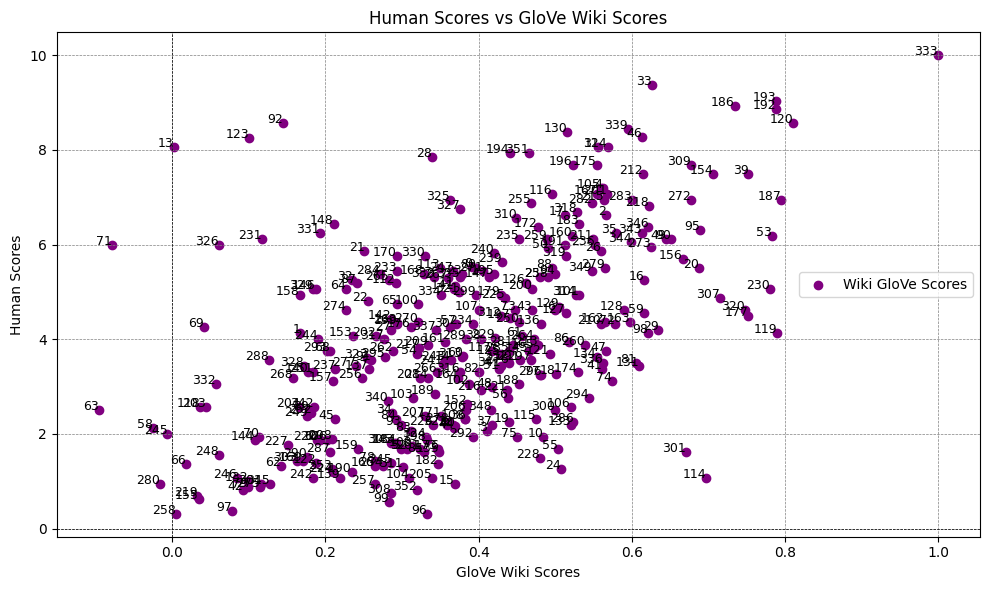

In [8]:
# Scatterplot for similarity scores from Wikipedia GloVe
plt.figure(figsize=(10, 6))
plt.scatter(data_wordsim['Scores Wiki'], data_wordsim['Human (Mean)'], color='purple', label='Wiki GloVe Scores')

# Adding labels for each point
for index, row in data_wordsim.iterrows():  # Use iterrows() to safely access row data
    plt.annotate(f"{index}", (row['Scores Wiki'], row['Human (Mean)']), fontsize=9, ha='right')


# Adding titles and labels
plt.title('Human Scores vs GloVe Wiki Scores')
plt.xlabel('GloVe Wiki Scores')
plt.ylabel('Human Scores')
plt.axhline(0, color='black',linewidth=0.5, ls='--')
plt.axvline(0, color='black',linewidth=0.5, ls='--')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.tight_layout()
plt.show()


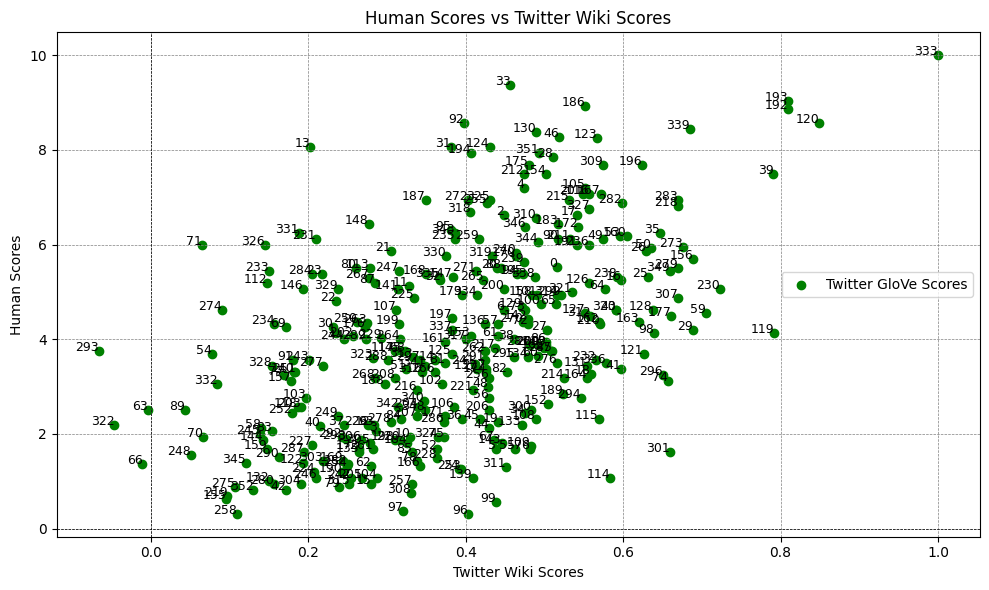

In [9]:
#  Scatterplot for similarity scores from Twitter GloVe
plt.figure(figsize=(10, 6))
plt.scatter(data_wordsim['Scores Twitter'], data_wordsim['Human (Mean)'], color='green', label='Twitter GloVe Scores')

# Adding labels for each point
for index, row in data_wordsim.iterrows():  # Use iterrows() to safely access row data
    plt.annotate(f"{index}", (row['Scores Twitter'], row['Human (Mean)']), fontsize=9, ha='right')


# Adding titles and labels
plt.title('Human Scores vs Twitter Wiki Scores')
plt.xlabel('Twitter Wiki Scores')
plt.ylabel('Human Scores')
plt.axhline(0, color='black',linewidth=0.5, ls='--')
plt.axvline(0, color='black',linewidth=0.5, ls='--')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.tight_layout()
plt.show()


**Your interpretation:**

•⁠  ⁠Both plots displayed results that are very similar to the Spearman correlation.

•⁠  ⁠When checking for outliers in the plots (that can be found naievely phrased in the top-left and bottom-right corners 
  of the scatterplots), it can be inferred that there are more outliers in the wiki plot than in the twitter plot.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 6: Find Outliers</b> 
</div>

In the second to last task, we ask you to print out a table (e.g. a pandas dataframe) containing every word pair and the absolute difference between the predicted and human-generated similarity score in descending order (Starting with the word pair for which the similarities differ the most).

Please implement the following steps for both models:
- calculate the absolute difference between the predicted and human-generated similarity scores. To obtain meaningful scores here, please first normalize the data using below function.
- print out a table showing the word pairs and their absolute difference score.
- For which pairs you get high and low scores, respectively? Does this make sense?


In [10]:
# Function to apply min max normalization to a list
# source: https://stats.stackexchange.com/questions/70801/how-to-normalize-data-to-0-1-range
def min_max_normalize(data):
    # lowest in value in list
    min_val = min(data)
    # highest values in list
    max_val = max(data)
    
    normalized_data = [(x - min_val) / (max_val - min_val) for x in data]

    return normalized_data

# Since our scores from the human annotator are between 1 - 10, we want to convert these scores to the scale from 0 - 1.
data_wordsim['Normalized Human Scores'] = min_max_normalize(data_wordsim['Human (Mean)'])
data_wordsim

,Word 1,Word 2,Human (Mean),Scores Wiki,Scores Twitter,Normalized Human Scores
0,admission,ticket,5.5360,0.391404,0.515912,0.539200
1,alcohol,chemistry,4.1250,0.167053,0.234922,0.393548
2,aluminum,metal,6.6250,0.566311,0.448135,0.651613
3,announcement,effort,2.0625,0.411360,0.286589,0.180645
4,announcement,news,7.1875,0.561814,0.473812,0.709677
...,...,...,...,...,...,...
346,war,troops,6.3750,0.621666,0.475672,0.625806
348,weapon,secret,2.5000,0.416717,0.348478,0.225806
349,weather,forecast,5.4375,0.548317,0.659692,0.529032
351,wood,forest,7.9375,0.466030,0.492734,0.787097


In [11]:
# Wikipedia GloVe
# Calculate absolute difference between similarity scores
abs_difference_wiki = abs(data_wordsim['Normalized Human Scores'] - data_wordsim['Scores Wiki'])
# Create table
table_diff_wiki = pd.DataFrame(dict(Word_1=data_wordsim['Word 1'], Word_2=data_wordsim['Word 2'], Absolute_Differences=abs_difference_wiki))
# Sort the table in descending order by Absolute_Differences
table_diff_wiki = table_diff_wiki.sort_values(by='Absolute_Differences', ascending=False)
# Print table
table_diff_wiki

,Word_1,Word_2,Absolute_Differences
13,asylum,madhouse,0.798274
123,fuck,sex,0.718805
92,dollar,buck,0.707270
71,cup,tableware,0.666185
114,five,month,0.618607
...,...,...,...
73,day,dawn,0.002923
155,king,cabbage,0.002594
227,peace,insurance,0.001850
343,vodka,brandy,0.000062


In [12]:
# Twitter GloVe
# Calculate absolute difference between similarity scores
abs_difference_twitter = abs(data_wordsim['Normalized Human Scores'] - data_wordsim['Scores Twitter'])
# Create table
table_diff_twitter = pd.DataFrame(dict(Word_1=data_wordsim['Word 1'], Word_2=data_wordsim['Word 2'], Absolute_Differences=abs_difference_twitter))
# Sort the table in descending order by Absolute_Differences
table_diff_twitter = table_diff_twitter.sort_values(by='Absolute_Differences', ascending=False)
# Print table
table_diff_twitter

,Word_1,Word_2,Absolute_Differences
13,asylum,madhouse,0.597764
301,start,year,0.523984
71,cup,tableware,0.521904
114,five,month,0.504932
33,car,automobile,0.478154
...,...,...,...
120,football,soccer,0.002761
160,law,lawyer,0.002225
218,news,report,0.001933
161,lawyer,evidence,0.000588


In [13]:
# Each z-score tells us how many standard deviations away an individual value is from the mean.
# We can say that a z-score higher than 3 is an outlier (source: https://www.machinelearningplus.com/machine-learning/how-to-detect-outliers-with-z-score/#:~:text=If%20the%20z%20score%20of,data%20point%20being%20an%20outlier.)
import scipy.stats as stats

# Wikipedia GloVe (Outliers)
# only keep rows where the z score of the absolute differences is smaller than 3.
table_diff_wiki = table_diff_wiki[abs(stats.zscore(table_diff_wiki["Absolute_Differences"])<3)]
table_diff_wiki

,Word_1,Word_2,Absolute_Differences
231,physics,proton,0.483406
28,boy,lad,0.438959
148,jaguar,cat,0.421698
331,tiger,mammal,0.419831
24,board,recommendation,0.411269
...,...,...,...
73,day,dawn,0.002923
155,king,cabbage,0.002594
227,peace,insurance,0.001850
343,vodka,brandy,0.000062


In [14]:
# Each z-score tells us how many standard deviations away an individual value is from the mean.
# We can say that a z-score higher than 3 is an outlier (source: https://www.machinelearningplus.com/machine-learning/how-to-detect-outliers-with-z-score/#:~:text=If%20the%20z%20score%20of,data%20point%20being%20an%20outlier.)
import scipy.stats as stats

# Twitter GloVe (Outliers)
# only keep rows where the z score of the absolute differences is smaller than 3.
table_diff_twitter = table_diff_twitter[abs(stats.zscore(table_diff_twitter["Absolute_Differences"])<3)]
table_diff_twitter

,Word_1,Word_2,Absolute_Differences
33,car,automobile,0.478154
92,dollar,buck,0.453217
326,tiger,carnivore,0.442489
331,tiger,mammal,0.425358
293,size,prominence,0.420953
...,...,...,...
120,football,soccer,0.002761
160,law,lawyer,0.002225
218,news,report,0.001933
161,lawyer,evidence,0.000588


**Your interpretation:**

•⁠  ⁠After applying the z-scores to the absolute differences, we have eliminated the outliers from each dataframe and according to the number of rows dropped on each model, we can see that we have more outliers for the wiki_model than for the twitter_model.

•⁠  ⁠The decreasing of rows coincides with our previous interpretations of both scatterplots about spoting some outliers in the graphs.

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 7: Find Outliers</b> 
</div>


Finally, we want to compare the word representations from the Wikipedia GloVe with the vectors from Twitter GloVe. We ask you to plot the similarity scores and print out a table with difference scores similarly to previous tasks.
​
Please implement the following steps:
- Check if both the Wikipedia and Twitter model yield word embeddings for the same set of word pairs. If not, filter the lists of predicted similarity scores such that you obtain a list of similarity scores with matching word pairs.
- Plot the similarity scores as in Step 5. Now, please plot the similarities predicted by the Wikipedia Glove as a function of the similarities predicted by the Twitter model.
- Print out a table showing the word pairs and their absolute difference score (in terms of similarity scores of both models) in descending order, as in Task 6.
- What can you infer from the results? Are the similarity predictions of both models similar or not?

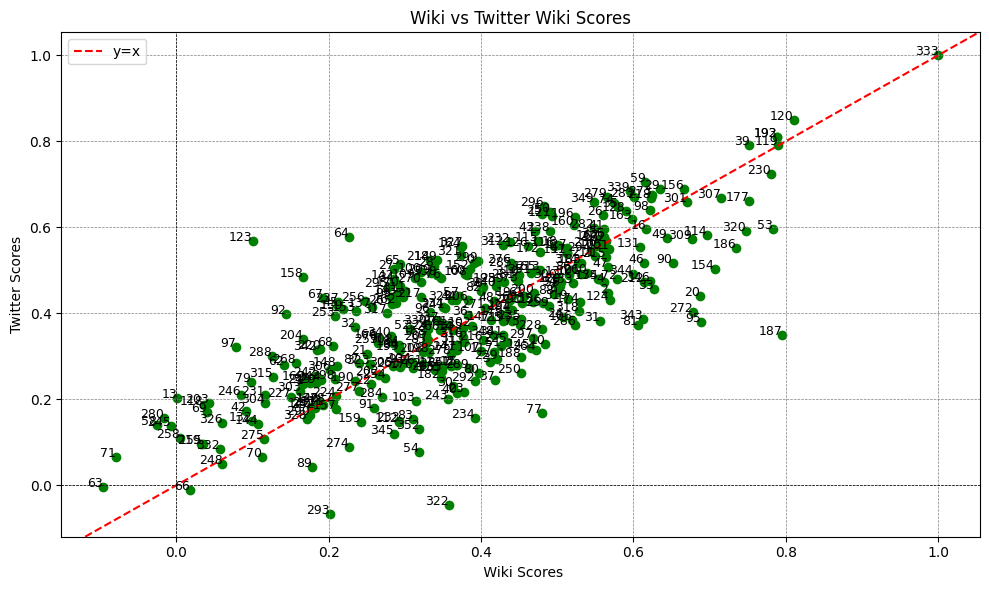

In [15]:
# Scatterplot similarities of Wikipedia and Twitter model

plt.figure(figsize=(10, 6))
plt.scatter(data_wordsim['Scores Wiki'], data_wordsim['Scores Twitter'], color='green')

# Adding labels for each point
for index, row in data_wordsim.iterrows():  # Use iterrows() to safely access row data
    plt.annotate(f"{index}", (row['Scores Wiki'], row['Scores Twitter']), fontsize=9, ha='right')


# Adding titles and labels
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='y=x')  # Line y=x for reference
plt.title('Wiki vs Twitter Wiki Scores')
plt.xlabel(' Wiki Scores')
plt.ylabel('Twitter Scores')
plt.axhline(0, color='black',linewidth=0.5, ls='--')
plt.axvline(0, color='black',linewidth=0.5, ls='--')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# Print out table representing word pairs and absolute difference between similarity scores of both models
abs_difference_models = abs(data_wordsim['Scores Wiki'] - data_wordsim['Scores Twitter'])
# Create table
table_diff_models = pd.DataFrame(dict(Word_1=data_wordsim['Word 1'], Word_2=data_wordsim['Word 2'], Absolute_Differences=abs_difference_models))
# Sort the table in descending order by Absolute_Differences
table_diff_models = table_diff_models.sort_values(by='Absolute_Differences', ascending=False)
# Print table
table_diff_models

,Word_1,Word_2,Absolute_Differences
123,fuck,sex,0.466780
187,mile,kilometer,0.446223
322,territory,kilometer,0.404681
64,cup,coffee,0.349378
158,lad,brother,0.317992
...,...,...,...
119,football,basketball,0.001952
224,opera,industry,0.001841
19,bed,closet,0.000639
251,prejudice,recognition,0.000564


**Your interpretation:**

•⁠  ⁠In the plots we can see that there is a  narrower distribution of the datapoints than in the plots before when comparing the model labels to   human labels.

•⁠  ⁠The scatterplots show that there are less outliers since they do a very similar job in the word similarity task.

•⁠  ⁠The correlation between the models is better than the correlation between the models and the human labels.

•⁠  ⁠Therefore, we can also inferthe above mentioned by looking at the absolute differences: the highes difference between the two models is less   than the highest difference between the models and the human labels, respectively.

## Task 2: Evaluate GloVe for Word Analogies

In [this week's paper](https://aclanthology.org/D14-1162/) (Section 4.1), the authors evaluated GloVe for word analogy task, and we will replicate this evaluation. In this setting, the model is used to solve questions following this pattern: 

> *a* is to *b* like *c* is to *???*. 

The objective is to predict the fourth word by finding the word with the most similar vector representation to: $ vector_a - vector_b  + vector_c $. With $ vector_a $ being the vector representation of the first word in the question. Examples are:

* *Paris* is to *France* like *Tokyo* is to **Japan**
* *Mouse* is to *mice* like *computer* is to **computers**

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load the Dataset</b> 
</div>

We will add another dataset containing the word analogy questions. Repeat the same steps as described in Task 1, but this time add the dataset [word-analogy-test](https://www.kaggle.com/datasets/julianschelb/word-analogy-test) dataset to your notebook and read the data as pandas dataframe. This dataset can be used to test a language model's capabilities in word analogy tasks. Every row contains a quadruple out of four word tokens. 

In [17]:
# Load the dataset as dataframe
data_analogy = pd.read_csv("/kaggle/input/word-analogy-test/questions-words.csv")

# Print the first five rows
data_analogy.head()

,row_id,category,word_one,word_two,word_three,word_four
0,0,capital-common-countries,Athens,Greece,Baghdad,Iraq
1,1,capital-common-countries,Athens,Greece,Bangkok,Thailand
2,2,capital-common-countries,Athens,Greece,Beijing,China
3,3,capital-common-countries,Athens,Greece,Berlin,Germany
4,4,capital-common-countries,Athens,Greece,Bern,Switzerland


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Load Models</b> 
</div>

We will load one addition model which yields word vectors of dimensionality 200 to compare it with the smaller models we used so far:

 * Load the larger model "glove-wiki-gigaword-200" 
 * Load the smaller model "glove-wiki-gigaword-50" 

In [18]:
# Load the model 
wiki_large = api.load('glove-wiki-gigaword-200')

wiki_small = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Make Predictions</b> 
</div>

After we loaded the datasets and models, we are now ready to make predictions. In this case, we want to predict the fourth word in our dataset to evaluate GloVe's performance. We ask you to do implement the following:

* Preprocess the dataset if necessary (*Hint: GloVe's vocabulary is lower case only*)
* Implement a function which takes word_one, word_two and word_three, and the model as parameters and predicts the missing fourth word using $ vector_a - vector_b  + vector_c $. (*Hint: Gensim provides the method [.most_similar()](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html), which already has this functionality implemented.*)
* Test your function with 'man', 'king' and 'woman'. The result should be 'queen'.


In [19]:
# Preprocessing
for key in data_analogy.keys()[2:]:
  data_analogy[key] = data_analogy[key].str.lower()

data_analogy.head()

,row_id,category,word_one,word_two,word_three,word_four
0,0,capital-common-countries,athens,greece,baghdad,iraq
1,1,capital-common-countries,athens,greece,bangkok,thailand
2,2,capital-common-countries,athens,greece,beijing,china
3,3,capital-common-countries,athens,greece,berlin,germany
4,4,capital-common-countries,athens,greece,bern,switzerland


In [20]:
# Function for prediction
def prediction(word1, word2, word3, model):
  return model.most_similar(positive=[word2, word3], negative=[word1])[0][0]

# Test the function
print(prediction('man', 'king', 'woman', wiki_large))
print(prediction('man', 'king', 'woman', wiki_small))

queen
queen


Now that you validated that your function works, we proceed by using the data in our evaluation dataset. Use the previous implemented function to predict the fourth word token and store the predictions in a new dataframe column. Do this for both models. Because the dataset contains 19544 data points, processing will take about 3-5 minutes. You can use a for loop, but generally speaking the [.apply())](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method is faster.

*Hint: For processing larger datasets, displaying the current progress is useful. The python package [tqdm](https://tqdm.github.io/docs/notebook/) can be used to display a progress bar and estimated time remaining.*

In [21]:
# Predictions
data_analogy['prediction large'] = data_analogy.apply(lambda row: prediction(row['word_one'], row['word_two'], row['word_three'], wiki_large), axis=1)

data_analogy['prediction small'] = data_analogy.apply(lambda row: prediction(row['word_one'], row['word_two'], row['word_three'], wiki_small), axis=1)

data_analogy.head()

,row_id,category,word_one,word_two,word_three,word_four,prediction large,prediction small
0,0,capital-common-countries,athens,greece,baghdad,iraq,iraq,iraq
1,1,capital-common-countries,athens,greece,bangkok,thailand,thailand,thailand
2,2,capital-common-countries,athens,greece,beijing,china,china,china
3,3,capital-common-countries,athens,greece,berlin,germany,germany,germany
4,4,capital-common-countries,athens,greece,bern,switzerland,switzerland,schaffhausen


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 4: Interpret Results</b> 
</div>

In this final step, we ask you to evaluate the predictions produced by both models by completing the following tasks:

* Compare the predicted word token with the correct token in the dataset (word_fourth).
* Calculate the overall accuracy achieved for each model.
* Calculate the accuracy per category and visualize the result as [bar chart(s)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html). 
* Finally, write a few sentences about how you interpret the results.

*Hint: For processing and aggregating dataframes the methods [.groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) and [.aggregate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.aggregate.html) are commonly used.*

In [22]:
from sklearn.metrics import accuracy_score
# Compare prediction with ground truth for both models
# Compare predicted words with the correct tokens for both models
data_analogy['Match_50'] = data_analogy['prediction small'] == data_analogy['word_four']
data_analogy['Match_200'] = data_analogy['prediction small'] == data_analogy['word_four']

# Calculate overall accuracy for both models

accuracy_small = accuracy_score(data_analogy['word_four'], data_analogy['prediction small'])
accuracy_large = accuracy_score(data_analogy['word_four'], data_analogy['prediction large'])

# Print accuracy results
print(f"Accuracy of 50D Model: {accuracy_small}")
print(f"Accuracy of 200D Model: {accuracy_large}")

Accuracy of 50D Model: 0.4621878837494883
Accuracy of 200D Model: 0.6977077363896849


In [23]:
# Calculate accuracy per category for both models
# Calculate accuracy per category for the 50D model
category_accuracy_small = data_analogy.groupby('category').apply(
    lambda group: (group['prediction small'] == group['word_four']).mean()
)

# Calculate accuracy per category for the 200D model
category_accuracy_large = data_analogy.groupby('category').apply(
    lambda group: (group['prediction large'] == group['word_four']).mean()
)

# Display results
print("Accuracy per category for 50D Model:\n", category_accuracy_small.sort_values(ascending=True))
print("\nAccuracy per category for 200D Model:\n", category_accuracy_large.sort_values(ascending=True))

Accuracy per category for 50D Model:
 category
currency                       0.083141
gram2-opposite                 0.094828
gram1-adjective-to-adverb      0.152218
city-in-state                  0.153223
gram4-superlative              0.286096
gram9-plural-verbs             0.343678
gram7-past-tense               0.375000
gram5-present-participle       0.415720
gram3-comparative              0.518018
gram8-plural                   0.599099
capital-world                  0.684792
family                         0.689723
capital-common-countries       0.792490
gram6-nationality-adjective    0.859912
dtype: float64

Accuracy per category for 200D Model:
 category
currency                       0.172055
gram2-opposite                 0.226601
gram1-adjective-to-adverb      0.254032
city-in-state                  0.499797
gram9-plural-verbs             0.597701
gram7-past-tense               0.601923
gram5-present-participle       0.682765
gram4-superlative              0.697861
gram8-plu

/tmp/ipykernel_23/2649571115.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  category_accuracy_small = data_analogy.groupby('category').apply(
/tmp/ipykernel_23/2649571115.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  category_accuracy_large = data_analogy.groupby('category').apply(


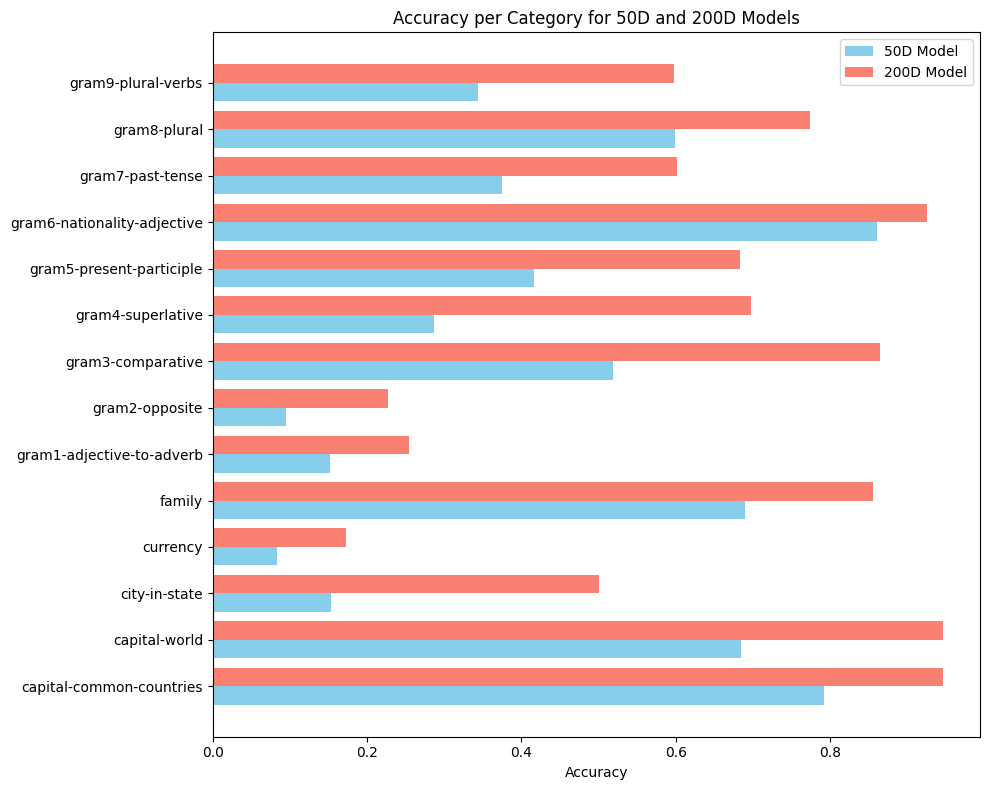

In [24]:
# Show plot
# Combine results into a DataFrame for easier plotting
accuracy_df = pd.DataFrame({
    'Category': category_accuracy_small.index,
    'Accuracy_50D': category_accuracy_small.values,
    'Accuracy_200D': category_accuracy_large.values
})

# Set the category as the index
accuracy_df.set_index('Category', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))

# Set bar width and positions
bar_width = 0.4
y = np.arange(len(accuracy_df))

# Create bars for each model
plt.barh(y - bar_width/2, accuracy_df['Accuracy_50D'], height=bar_width, label='50D Model', color='skyblue')
plt.barh(y + bar_width/2, accuracy_df['Accuracy_200D'], height=bar_width, label='200D Model', color='salmon')

# Add labels and title
plt.xlabel('Accuracy')
plt.title('Accuracy per Category for 50D and 200D Models')
plt.yticks(y, accuracy_df.index)  # Set the y-ticks to the categories
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

**Your interpretation:**

The larger model performed better in all categories, achieving higher accuracy. This suggests that the larger model generally captures semantic relationships between words better, likely due to having more dimensions to represent word meanings. Both models performed well in the capital-world, capital-common-countries, and gram6-nationality-adjective categories. However, some categories, such as opposite and currency, were challenging for both models. Generally, antonyms are not well captured by language models because their vector space structure is based on word co-occurrence, which doesn’t emphasize contrasting meanings.